# The difference between the Edelweiss resolution function and the true Yield variance

## The problem
We perform the fit to the data using an approximation to the yield variance, not the true yield variance.  This begs the question, "does this impact our answer significantly?"

## What this notebook investigates
This notebook samples the posterior distribution and, for each parameter set sampled, stores the difference between the true yield and the estimate used by the fit.

This notebook focuses on a single energy.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import numpy as np
import pandas as pd
from astropy.table import Table, Column, vstack
from astropy.io.misc.hdf5 import read_table_hdf5, write_table_hdf5

import sys
sys.path.append('../python/')
from EdwRes import *
from prob_dist import *
from checkDifference_yieldVariance import *

In [2]:
# get the data
# the posterior distribution is in samples
#filename = 'data/edelweiss_corr_C_systematicErrors_sampler_nll_allpars_gausPrior.h5'
#ndim, nwalkers, nsteps, samples = getPosteriorSamples(filename)

In [3]:
# We'll look at the Er values of the data points
# import data from Edelweiss
resNR_data = pd.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

# the sorting is necessary!
# otherwise the mask defined below will select the wrong data
resNR_data = resNR_data.sort_values(by='E_recoil')
NR_data = {'Erecoil': resNR_data["E_recoil"][2::], 'sigma': resNR_data["sig_NR"][2::], 'sigma_err': resNR_data["sig_NR_err"][2::]}
Er = np.sort(NR_data['Erecoil'])
Erecoil = Er[0]
#print (NR_data['Erecoil'])
#print (NR_data['sigma'])
#print (NR_data['sigma_err'])
#print (len(samples))
#print(np.random.randint(len(samples), size=10))

filenames = []
for Erecoil in NR_data['Erecoil']:
    filename = 'data/yield_accuracy_Erecoil_%.2f_keV_all_corrAB.h5' % Erecoil
    filenames.append(filename)
    
print (filenames)

['data/yield_accuracy_Erecoil_24.50_keV_all_corrAB.h5', 'data/yield_accuracy_Erecoil_34.22_keV_all_corrAB.h5', 'data/yield_accuracy_Erecoil_44.26_keV_all_corrAB.h5', 'data/yield_accuracy_Erecoil_58.40_keV_all_corrAB.h5', 'data/yield_accuracy_Erecoil_97.72_keV_all_corrAB.h5']


In [5]:
# read the data into a pandas dataframe
df_24keV = pd.read_hdf(filenames[0], key='table')
#df_34keV = pd.read_hdf(filenames[1], key='table')
#df_44keV = pd.read_hdf(filenames[2], key='table')
#df_58keV = pd.read_hdf(filenames[3], key='table')
df_97keV = pd.read_hdf(filenames[4], key='table')
#df_97keV.drop_duplicates()

df_24keV['Yield'] = df_24keV['A']*np.power(df_24keV['energy_recoil_keV'], df_24keV['B'])
df_97keV['Yield'] = df_97keV['A']*np.power(df_97keV['energy_recoil_keV'], df_97keV['B'])

In [8]:
np.sum(df_97keV['true_yield_sig'].notnull())
df_97keV[df_97keV['true_yield_sig'].notnull()].head(15)

,energy_recoil_keV,aH,C,m,scale,A,B,true_yield_sig,cor1_yield_sig,Yield
0,97.7172,0.037427,0.032614,0.000097,1.030084,0.170104,0.157978,0.017127,0.017422,0.350823
1,97.7172,0.037427,0.032614,0.000097,1.030084,0.170104,0.157978,0.017127,0.017422,0.350823
2,97.7172,0.037418,0.032699,0.000096,1.030249,0.170086,0.157301,0.017081,0.017388,0.349699
3,97.7172,0.037418,0.032699,0.000096,1.030249,0.170086,0.157301,0.017081,0.017388,0.349699
4,97.7172,0.037418,0.032699,0.000096,1.030249,0.170086,0.157301,0.017081,0.017388,0.349699
5,97.7172,0.035664,0.035542,0.000082,1.055421,0.155250,0.143285,0.015229,0.015876,0.299340
6,97.7172,0.035664,0.035542,0.000082,1.055421,0.155250,0.143285,0.015229,0.015876,0.299340
7,97.7172,0.035439,0.033696,0.000108,1.061339,0.152369,0.159578,0.015892,0.016357,0.316557
8,97.7172,0.034642,0.035121,0.000079,1.026354,0.163141,0.159384,0.016338,0.016740,0.338636
9,97.7172,0.034293,0.035936,0.000061,1.028829,0.162778,0.157221,0.016161,0.016602,0.334550


In [7]:
"""it = zip(NR_data['Erecoil'], NR_data['sigma'], NR_data['sigma_err'], [df_24keV,df_34keV, df_44keV, df_58keV, df_97keV])
for Erecoil, sig, sig_err, df in it:
    fig1 = plt.hist(100*(df['true_yield_sig'] - df['cor1_yield_sig'])/df['true_yield_sig'], bins='auto')
    plt.title('%.2f keV' % Erecoil)
    plt.xlabel('percent of true value')
    plt.show()"""

"it = zip(NR_data['Erecoil'], NR_data['sigma'], NR_data['sigma_err'], [df_24keV,df_34keV, df_44keV, df_58keV, df_97keV])\nfor Erecoil, sig, sig_err, df in it:\n    fig1 = plt.hist(100*(df['true_yield_sig'] - df['cor1_yield_sig'])/df['true_yield_sig'], bins='auto')\n    plt.title('%.2f keV' % Erecoil)\n    plt.xlabel('percent of true value')\n    plt.show()"

In [8]:
#hist, bin_edges = np.histogram(df['true_yield_sig'] - df['cor1_yield_sig'], bins='auto')

(array([  48.,  221.,  735., 1052., 1231.,  827.,  426.,  190.,   40.,
          30.]),
 array([0.10744435, 0.11768144, 0.12791853, 0.13815562, 0.14839271,
        0.1586298 , 0.16886689, 0.17910398, 0.18934107, 0.19957816,
        0.20981525]),
 <a list of 10 Patch objects>)

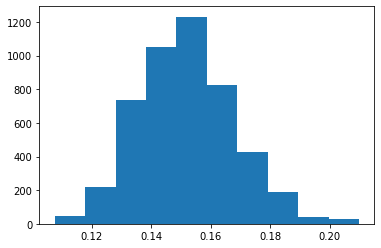

In [9]:
plt.hist(df_24keV['A'])

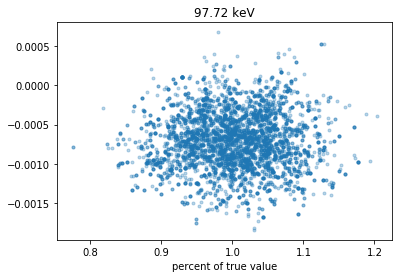

In [11]:
fig1 = plt.plot(df_24keV['scale'], df_24keV['true_yield_sig'] - df_24keV['cor1_yield_sig'],'.', alpha=0.3)
plt.title('%.2f keV' % Erecoil)
plt.xlabel('percent of true value')
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression

In [44]:
mask = df_24keV['true_yield_sig'].notnull()
y = df_24keV[mask]['true_yield_sig'] - df_24keV[mask]['cor1_yield_sig']
X = df_24keV[mask][['aH', 'scale', 'A', 'B']]

In [45]:
reg = LinearRegression().fit(X, y)

In [46]:
reg.score(X, y)

0.9861906610018532

In [47]:
print ("coefficents: ", reg.coef_)
print ("intercept: ", reg.intercept_)

coefficents:  [0.00332374 0.00118037 0.01465796 0.02026259]
intercept:  -0.00781103093906066


In [48]:
aH, scale, A, B = 0.0381, 1, 0.16, 0.18
X0 = np.array([[aH, scale, A, B]])
reg.predict(X0)

array([-0.00051149])

In [49]:
#df_24keV['cor2_yield_sig'] = reg.predict(df_24keV[['aH', 'C', 'm', 'scale', 'A', 'B']])
df_24keV['cor2_yield_sig'] = reg.predict(df_24keV[['aH', 'scale', 'A', 'B']])

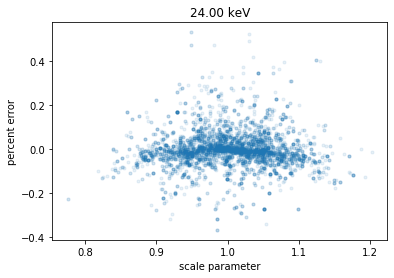

In [50]:
percent_err = 100*(df_24keV['true_yield_sig'] - (df_24keV['cor1_yield_sig'] + df_24keV['cor2_yield_sig']))/df_24keV['true_yield_sig']
fig1 = plt.plot(df_24keV['scale'], percent_err,'.', alpha=0.1)
plt.title('%.2f keV' % 24)
plt.xlabel('scale parameter')
plt.ylabel('percent error')
plt.show()

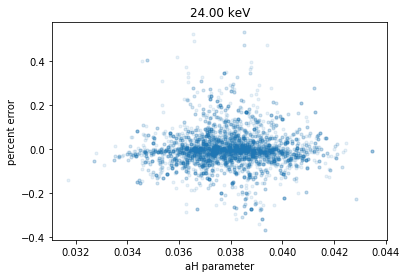

In [51]:
parameter_str = 'aH'
fig1 = plt.plot(df_24keV[parameter_str], percent_err,'.', alpha=0.1)
plt.title('%.2f keV' % 24)
plt.xlabel('%s parameter' % parameter_str)
plt.ylabel('percent error')
plt.show()

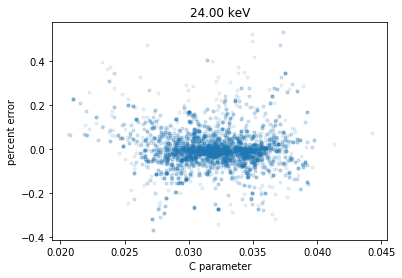

In [52]:
parameter_str = 'C'
fig1 = plt.plot(df_24keV[parameter_str], percent_err,'.', alpha=0.1)
plt.title('%.2f keV' % 24)
plt.xlabel('%s parameter' % parameter_str)
plt.ylabel('percent error')
plt.show()

Series([], Name: Yield, dtype: float64)
0.18007979571657617 0.3424714574603501


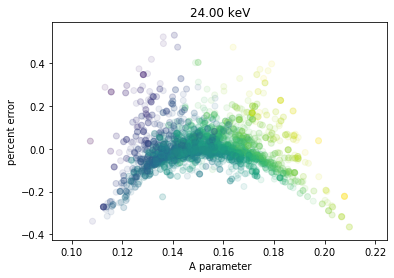

In [53]:
parameter_str = 'A'
colors = df_24keV['Yield']
colors[colors.isnull()] = 0
print (colors[colors.isnull()])
colors[colors < 0] = 0
#colors = np.array(colors)
print(np.min(colors), np.max(colors))
fig1 = plt.scatter(df_24keV[parameter_str], percent_err, c=colors, alpha=0.1)
plt.title('%.2f keV' % 24)
plt.xlabel('%s parameter' % parameter_str)
plt.ylabel('percent error')
plt.show()

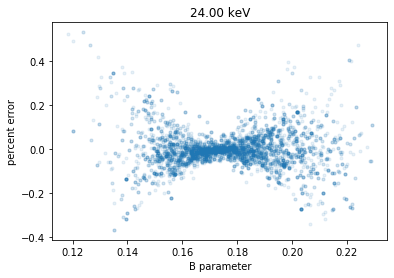

In [54]:
parameter_str = 'B'
fig1 = plt.plot(df_24keV[parameter_str], percent_err,'.', alpha=0.1)
plt.title('%.2f keV' % 24)
plt.xlabel('%s parameter' % parameter_str)
plt.ylabel('percent error')
plt.show()

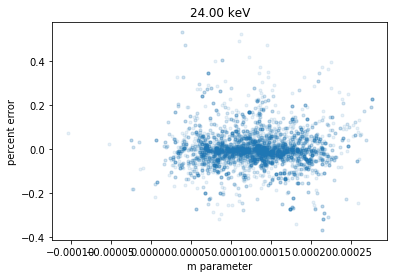

In [55]:
parameter_str = 'm'
fig1 = plt.plot(df_24keV[parameter_str], percent_err,'.', alpha=0.1)
plt.title('%.2f keV' % 24)
plt.xlabel('%s parameter' % parameter_str)
plt.ylabel('percent error')
plt.show()

Series([], Name: scale, dtype: float64)
0.7750299463599697 1.2034321067008702


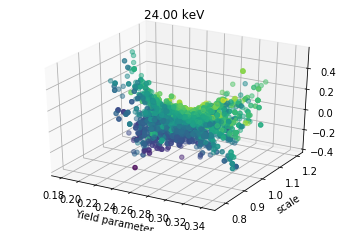

In [56]:
from mpl_toolkits.mplot3d import Axes3D
colors = df_24keV['scale']
colors[colors.isnull()] = 0
print (colors[colors.isnull()])
colors[colors < 0] = 0
#colors = np.array(colors)
print(np.min(colors), np.max(colors))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

parameter_str = 'Yield'
fig1 = ax.scatter(df_24keV[parameter_str], colors, percent_err, c=colors, alpha=0.5)
plt.title('%.2f keV' % 24)
plt.xlabel('%s parameter' % parameter_str)
plt.ylabel('scale')
#plt.zlabel('percent error')
plt.show()

Series([], dtype: float64)
0.0 0.5325456683545927


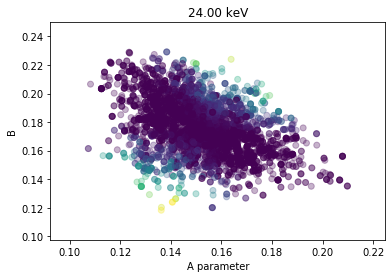

In [57]:
parameter_str = 'A'
colors = percent_err #df_24keV['Yield']
colors[colors.isnull()] = 0
print (colors[colors.isnull()])
colors[colors < 0] = 0
#colors = np.array(colors)
print(np.min(colors), np.max(colors))
fig1 = plt.scatter(df_24keV['A'], df_24keV['B'], c=colors, alpha=0.3)
plt.title('%.2f keV' % 24)
plt.xlabel('%s parameter' % parameter_str)
plt.ylabel('B')
plt.show()